In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import uniform_shell_sampler, make_nice_plots, fast_z_at_value
from scipy import stats
from tqdm import tqdm
from scipy.special import erf
from default_arguments import DEFAULT_COSMOLOGY
import astropy.units as u
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from astropy.constants import c
import time
from numpy.random import default_rng
from concurrent.futures import as_completed, ThreadPoolExecutor
from multiprocessing import cpu_count

make_nice_plots()


In [57]:
# def get_rng(i):
#     return i, uniform_shell_sampler(0, 10, 10)[0]

# ncpu = 4
# n = 10
# with ThreadPoolExecutor(max_workers=ncpu) as executor:
#     future_to_index = {executor.submit(
#                                     get_rng, 
#                                     index
#                                 ): index for index in range(n)
#                                 }
    
#     for future in tqdm(as_completed(future_to_index), total=n):
#         try:
#             i, num = future.result(timeout=20)
#             print(i, num)
#         except Exception as e:
#             print(f"Error processing event {future_to_index[future]}: {e}")


#### Now we are increasing the complexity by using comoving distances, luminosity distances and redshifts

/var/tmp/pouw/ipykernel_1274167/839877280.py:26: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf( (r_thresh - r) / (np.sqrt(2) * r_err * r)) )
/var/tmp/pouw/ipykernel_1274167/839877280.py:65: RuntimeWarning: invalid value encountered in scalar divide
  empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true


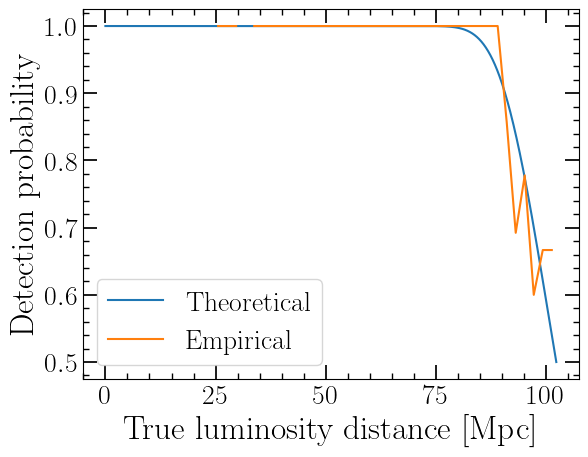

Detection probability: 1
Detected: 100 from AGN and 100 from ALT.


In [58]:
####################################################################
SPEED_OF_LIGHT_KMS = c.to('km/s').value
GW_DIST_ERR = 0.1  # Relative error
COMDIST_MIN = 0
COMDIST_MAX = 100  # Maximum comoving distance in Mpc
NAGN = int(1e2)
NGW_ALT = int(1e2)
NGW_AGN = int(1e2)
N_POST_SAMPS = int(1e5)
N_MC_SAMPS = int(1e4)
rr = np.linspace(COMDIST_MIN, COMDIST_MAX, 1000)
CHUNK = int(100)

COSMO = DEFAULT_COSMOLOGY
ZMIN = 0
ZMAX = fast_z_at_value(COSMO.comoving_distance, COMDIST_MAX * u.Mpc)
LUMDIST_MIN = COSMO.luminosity_distance(ZMIN).value
LUMDIST_MAX = COSMO.luminosity_distance(ZMAX).value

USE_GW_SELECTION_EFFECTS = False
LUMDIST_THRESH_GW = LUMDIST_MAX  # Luminosity distance threshold in Mpc
####################################################################


def detection_prob(r, r_thresh, r_err):
    return 0.5 * (1 + erf( (r_thresh - r) / (np.sqrt(2) * r_err * r)) )


# AGN catalog
agn_rcom, _, _ = uniform_shell_sampler(COMDIST_MIN, COMDIST_MAX, NAGN)  # NO AGN NEEDED ABOVE RMAX_GW, p_rate = 0
agn_z = fast_z_at_value(COSMO.comoving_distance, agn_rcom * u.Mpc)
agn_rlum = COSMO.luminosity_distance(agn_z).value

# GWs & likelihood
# GENERATE GWS UP TO RMAX_GW
true_rcom_gw_alt, _, _ = uniform_shell_sampler(COMDIST_MIN, COMDIST_MAX, NGW_ALT)
true_rcom_gw_agn = np.random.choice(agn_rcom, NGW_AGN)
true_rcom_all = np.append(true_rcom_gw_agn, true_rcom_gw_alt)

true_z_gw_alt = fast_z_at_value(COSMO.comoving_distance, true_rcom_gw_alt * u.Mpc)
true_z_gw_agn = fast_z_at_value(COSMO.comoving_distance, true_rcom_gw_agn * u.Mpc)
true_z_all = fast_z_at_value(COSMO.comoving_distance, true_rcom_all * u.Mpc)

true_rlum_gw_alt = COSMO.luminosity_distance(true_z_gw_alt).value
true_rlum_gw_agn = COSMO.luminosity_distance(true_z_gw_agn).value
true_rlum_all = COSMO.luminosity_distance(true_z_all).value

# MEASURE
obs_rlum_gw_alt = true_rlum_gw_alt * (1. + GW_DIST_ERR * np.random.normal(size=NGW_ALT))
obs_rlum_gw_agn = true_rlum_gw_agn * (1. + GW_DIST_ERR * np.random.normal(size=NGW_AGN))
obs_rlum_all = np.append(obs_rlum_gw_agn, obs_rlum_gw_alt)


### CHECK IF DETECTION PROB IS CORRECT ###
xx = np.linspace(0, LUMDIST_MAX, 1000)
plt.figure()
plt.plot(xx, detection_prob(xx, LUMDIST_THRESH_GW, GW_DIST_ERR), label='Theoretical')
edges = np.linspace(0, LUMDIST_MAX, 51)
empericial_detection_prob = np.zeros(len(edges) - 1)
for i in range(len(edges) - 1):
    selec = (true_rlum_all > edges[i]) & (true_rlum_all < edges[i + 1])
    data_in_bin = obs_rlum_all[selec]
    n_gws_in_bin_true = len(data_in_bin)
    n_gws_in_bin_obs = np.sum(data_in_bin < LUMDIST_THRESH_GW)
    empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true
plt.plot(edges[:-1] + np.diff(edges)[0] * 0.5, empericial_detection_prob, label='Empirical')
plt.xlabel('True luminosity distance [Mpc]')
plt.ylabel('Detection probability')
plt.legend()
plt.show()
###########################################


if USE_GW_SELECTION_EFFECTS:
    # ONLY KEEP EVENTS WITH OBSERVED DISTANCES BELOW THRESHOLD
    obs_rlum_gw_alt = obs_rlum_gw_alt[obs_rlum_gw_alt < LUMDIST_THRESH_GW]
    obs_rlum_gw_agn = obs_rlum_gw_agn[obs_rlum_gw_agn < LUMDIST_THRESH_GW]
    obs_rlum_all = np.append(obs_rlum_gw_agn, obs_rlum_gw_alt)
    p_det = np.sum( detection_prob(agn_rlum, LUMDIST_THRESH_GW, GW_DIST_ERR) ) / len(agn_rlum)
else:
    p_det = 1

print(f'Detection probability: {p_det}')
print(f'Detected: {len(obs_rlum_gw_agn)} from AGN and {len(obs_rlum_gw_agn)} from ALT.')



In [59]:
def dVdz_unnorm(z, cosmo):
    '''Assuming flat LCDM'''
    Omega_m = cosmo.Om0
    Omega_Lambda = 1 - Omega_m
    E_of_z = np.sqrt((1 + z)**3 * Omega_m + Omega_Lambda)
    com_vol = ((1 + z) * cosmo.angular_diameter_distance(z).value)**2 / E_of_z
    return com_vol


func = lambda z: dVdz_unnorm(z, COSMO)
NORM = quad(func, ZMIN, ZMAX)[0]  # NORMALIZE UP TO ZMAX, since p_rate(z > ZMAX) = 0


def dVdz_prior(z, norm=NORM, cosmo=COSMO):
    z = np.atleast_1d(z)
    result = np.zeros_like(z)
    below_thresh = z < ZMAX
    result[below_thresh] = dVdz_unnorm(z[below_thresh], cosmo) / norm
    return result


In [ ]:
LUMDIST_AT_MAX_REDSHIFT = COSMO.luminosity_distance(999).value

def generate_posterior(rlum_obs, rlum_relerr=GW_DIST_ERR, n_posterior_samples=N_POST_SAMPS):
    # Importance resampling of distances
    dtrue_postsamps = rlum_obs / (1 + rlum_relerr * np.random.normal(size=4 * n_posterior_samples))
    neg = dtrue_postsamps < 0
    # if np.sum(neg) != 0:
    #     print(f'Removing {np.sum(neg)} negative luminosity distance samples.')
    dtrue_postsamps = dtrue_postsamps[~neg]  # WARNING: Negative values are very rare, (20% (30%) error, 50k (100k) postsamps, 1 (180) negative samp), so just remove them. But be aware!
    weights = dtrue_postsamps / np.sum(dtrue_postsamps)  # Importance weights proportional to d
    lumdist_samples = np.random.choice(dtrue_postsamps, size=2 * n_posterior_samples, p=weights)
    
    n_samps_above_max_z = np.sum(lumdist_samples > LUMDIST_AT_MAX_REDSHIFT)
    if n_samps_above_max_z != 0:
        lumdist_samples = lumdist_samples[lumdist_samples > LUMDIST_AT_MAX_REDSHIFT]
        print(f'Removing {n_samps_above_max_z} samples at too high luminosity distance ({LUMDIST_AT_MAX_REDSHIFT:.2f}).')
    
    # Redshift reweighting
    z_samples = fast_z_at_value(COSMO.luminosity_distance, lumdist_samples * u.Mpc)
    H_z = COSMO.H(z_samples).value  # H(z) in km/s/Mpc
    chi_z = (1 + z_samples) * lumdist_samples
    dDL_dz = chi_z + (1 + z_samples) * (SPEED_OF_LIGHT_KMS / H_z)  # c = 3e5 km/s
    z_weights = 1 / dDL_dz
    z_weights /= np.sum(z_weights)
    z_samples = np.random.choice(z_samples, n_posterior_samples, p=z_weights)
    return z_samples


# def gw_processing(rlum_obs, agn_z, n_mc_samps=N_MC_SAMPS):
#     Ngw = len(rlum_obs)
#     p_agn = np.zeros(Ngw)
#     p_alt = np.zeros(Ngw)
#     kdes = []
#     for i, obs in tqdm(enumerate(rlum_obs), total=Ngw):
#         gw_z_posterior = generate_posterior(obs)
#         kde_gw_z_posterior = gaussian_kde(gw_z_posterior)
#         p_agn[i] = np.sum(kde_gw_z_posterior(agn_z)) / len(agn_z)
        
#         idx_array = np.random.choice(np.arange(len(gw_z_posterior)), size=n_mc_samps)
#         mc_redshift = gw_z_posterior[idx_array]
#         mc_samps_below_thresh = mc_redshift[mc_redshift < ZMAX]
#         p_alt[i] = np.sum( dVdz_prior(mc_samps_below_thresh) ) / n_mc_samps

#         kdes.append(kde_gw_z_posterior)
#     return p_agn, p_alt, kdes


def gw_processing_thread(index, rlum_obs, agn_z, n_mc_samps=N_MC_SAMPS):
    # start_total = time.time()

    gw_z_posterior = generate_posterior(rlum_obs)
    # print('post gen', time.time() - start_total)

    # Avoid outliers messing up the KDE!
    trimmed = gw_z_posterior[(gw_z_posterior > np.percentile(gw_z_posterior, 0.1)) & (gw_z_posterior < np.percentile(gw_z_posterior, 99.9))]
    kde_gw_z_posterior = gaussian_kde(trimmed)
    p_agn = np.sum(kde_gw_z_posterior(agn_z)) / len(agn_z)
    # print(p_agn)
    
    # print(len(gw_z_posterior[gw_z_posterior < ZMAX]))
    mc_samps = np.random.choice(gw_z_posterior, size=n_mc_samps)
    mc_samps_below_thresh = mc_samps[mc_samps < ZMAX]
    p_alt = np.sum( dVdz_prior(mc_samps_below_thresh) ) / n_mc_samps
    # print(p_alt)
    # print(p_alt1, 'mc')



    # mean_z = np.mean(gw_z_posterior)
    # z_array = np.linspace(mean_z / 10, mean_z * 2, 1000)
    # selec = (gw_z_posterior > mean_z / 10) & (gw_z_posterior < mean_z * 2)
    # fig, ax = plt.subplots()
    # prior_ax = ax.twinx()
    # ax.hist(gw_z_posterior[selec], density=True, bins=50)
    # prior_ax.plot(z_array, dVdz_prior(z_array), color='blue', label='ALT hyp.')
    # ax.plot(z_array, kde_gw_z_posterior(z_array), color='red', label='KDE')
    # prior_ax.hist(agn_z, density=True, bins=30)
    # # plt.plot(z_array, func2integrate(z_array), color='black', label='Product')
    # plt.legend()
    # # plt.semilogy()
    # # plt.savefig('mc.pdf')
    # plt.show()



    # func2integrate = lambda z: kde_gw_z_posterior(z) * dVdz_prior(z)
    # p_alt = quad(func2integrate, ZMIN, ZMAX)[0]



    # if (p_alt1 / p_alt > 1.2) or (p_alt1 / p_alt < 1/1.2):
    #     mean_z = np.mean(gw_z_posterior)
    #     z_array = np.linspace(mean_z / 10, mean_z * 2, 1000)
    #     selec = (gw_z_posterior > mean_z / 10) & (gw_z_posterior < mean_z * 2)
        
    #     print(np.sum(~np.isfinite(gw_z_posterior)), 'infinities')
    #     print(np.sum(np.isnan(gw_z_posterior)), 'nans')

    #     print(len(gw_z_posterior[gw_z_posterior < ZMAX]))
    #     print(p_alt1, p_alt)
    #     fig, ax = plt.subplots()
    #     prior_ax = ax.twinx()
    #     ax.hist(gw_z_posterior[selec], density=True, bins=50)
    #     prior_ax.plot(z_array, dVdz_prior(z_array), color='blue', label='ALT hyp.')
    #     ax.plot(z_array, kde_gw_z_posterior(z_array), color='red', label='KDE')
    #     # plt.plot(z_array, func2integrate(z_array), color='black', label='Product')
    #     plt.legend()
    #     # plt.semilogy()
    #     # plt.savefig('mc.pdf')
    #     plt.show()
    # # # print('In total: ', time.time() - start_total)
    
    return index, p_agn, p_alt


In [61]:
# p_agn_agn_gws, p_alt_agn_gws, kdes_agn_gw = gw_processing(obs_rlum_gw_agn, agn_z[agn_z < ZMAX])
# p_agn_alt_gws, p_alt_alt_gws, kdes_alt_gw = gw_processing(obs_rlum_gw_alt, agn_z[agn_z < ZMAX])

In [62]:
# zz = np.linspace(ZMIN, ZMAX, 1000)

# # plt.figure()
# # plt.hist(agn_z, bins=30, density=True, label='AGN')
# # plt.plot(zz, dVdz_prior(zz), label='ALT hypothesis')
# # plt.plot(zz, kdes_agn_gw[0](zz), label='GW posterior')
# # plt.legend()
# # plt.xlabel('Redshift')
# # plt.ylabel('Probability density')
# # plt.show()

# plt.figure()
# plt.scatter(p_alt_agn_gws, p_agn_agn_gws, color='blue', marker='.')
# plt.scatter(p_alt_alt_gws, p_agn_alt_gws, color='red', marker='.')
# plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), color='black', linestyle='dashed')
# plt.loglog()
# plt.xlabel('ALT hypothesis evidence')
# plt.ylabel('AGN hypothesis evidence')
# plt.show()

# xmin = 1e-2
# xmax = 1e2
# xx = np.linspace(xmin, xmax, 100)

# edges = np.linspace(xmin, xmax, 31)
# plt.figure()
# plt.hist(p_agn_alt_gws, bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
# plt.hist(p_agn_agn_gws, bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# # plt.semilogx()
# plt.legend()
# plt.xlabel(r'$S_{\rm agn}$')
# plt.show()

# xmin = 1e-2
# xmax = 1e2
# edges = np.linspace(xmin, xmax, 31)

# plt.figure()
# plt.hist(p_alt_alt_gws, bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
# plt.hist(p_alt_agn_gws, bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# # plt.semilogx()
# plt.legend()
# plt.xlabel(r'$S_{\rm alt}$')
# plt.show()


In [63]:
ncpu = cpu_count()

n_agn_gw = len(obs_rlum_gw_agn)
p_agn_agn_gws_all = np.zeros(n_agn_gw)
p_alt_agn_gws_all = np.zeros(n_agn_gw)
error_idx_agn = []
with ThreadPoolExecutor(max_workers=ncpu) as executor:
    future_to_index = {executor.submit(
                                    gw_processing_thread, 
                                    index, 
                                    obs_rlum,
                                    agn_z[agn_z < ZMAX]
                                ): index for index, obs_rlum in enumerate(obs_rlum_gw_agn)
                                }
    
    for future in tqdm(as_completed(future_to_index), total=n_agn_gw):
        try:
            i, p_agn_result, p_alt_result = future.result(timeout=20)
            p_agn_agn_gws_all[i] = p_agn_result
            p_alt_agn_gws_all[i] = p_alt_result
        except Exception as e:
            print(f"Error processing event {future_to_index[future]}: {e}")
            error_idx_agn.append(future_to_index[future])


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


In [64]:
n_alt_gw = len(obs_rlum_gw_alt)
p_agn_alt_gws_all = np.zeros(n_alt_gw)
p_alt_alt_gws_all = np.zeros(n_alt_gw)
error_idx_alt = []
with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    future_to_index = {executor.submit(
                                    gw_processing_thread, 
                                    index, 
                                    obs_rlum,
                                    agn_z[agn_z < ZMAX]
                                ): index for index, obs_rlum in enumerate(obs_rlum_gw_alt)
                                }
    
    for future in tqdm(as_completed(future_to_index), total=n_alt_gw):
        try:
            i, p_agn_result, p_alt_result = future.result(timeout=20)
            p_agn_alt_gws_all[i] = p_agn_result
            p_alt_alt_gws_all[i] = p_alt_result
        except Exception as e:
            print(f"Error processing event {future_to_index[future]}: {e}")
            error_idx_alt.append(future_to_index[future])

100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


In [65]:
agn_mask = np.ones(len(p_agn_agn_gws_all), dtype=bool)
if len(error_idx_agn) != 0:
    agn_mask[np.array(error_idx_agn)] = False

p_agn_agn_gws = p_agn_agn_gws_all[agn_mask]
p_alt_agn_gws = p_alt_agn_gws_all[agn_mask]

alt_mask = np.ones(len(p_agn_alt_gws_all), dtype=bool)
if len(error_idx_alt) != 0:
    alt_mask[np.array(error_idx_alt)] = False
p_agn_alt_gws = p_agn_alt_gws_all[alt_mask]
p_alt_alt_gws = p_alt_alt_gws_all[alt_mask]


100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


[[167 166 175 ... 116 131 118]
 [ 18  68 107 ... 120 187 183]
 [ 52  27  41 ... 180 161 103]
 ...
 [ 97  21  19 ... 186 141 168]
 [ 12  14   6 ...  76 151 186]
 [ 12  42  22 ...  21  45  50]]


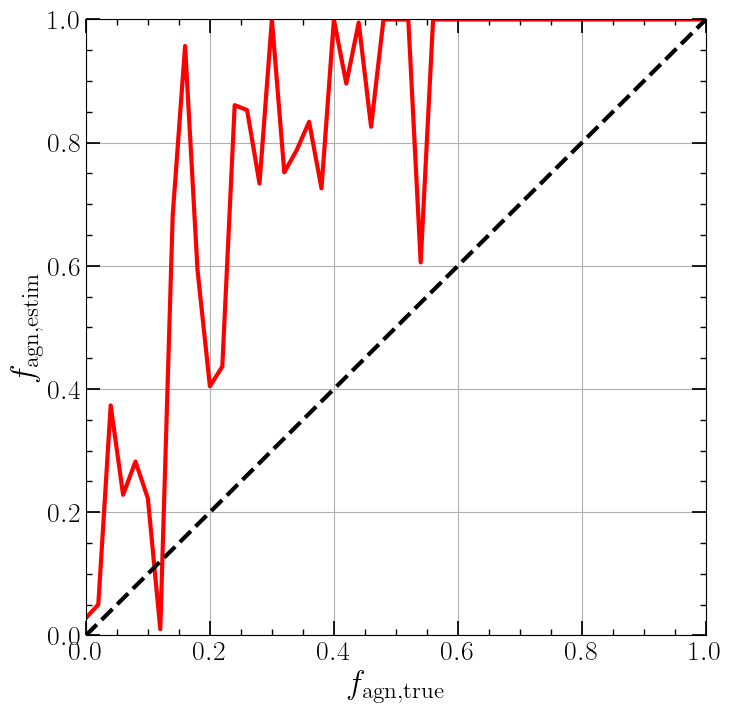

In [ ]:
### Some translations to reuse my code ###
cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
palt = cw_palt  # c = 1
agn_events = np.ones(int(len(p_agn_agn_gws) + len(p_agn_alt_gws)), dtype=bool)
agn_events[len(p_agn_agn_gws):] = 0
alt_events = ~agn_events
##########################################

use_N_gws = 100
n_trials = len(cw_pagn) // (2 * use_N_gws)

max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)

gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn


## These two lines are for making the underlying truth equal to the actual realization of that truth
use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
true_fagns = use_N_agn_events / use_N_gws
use_N_alt_events = use_N_gws - use_N_agn_events
realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth



if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    # true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    # use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    # use_N_alt_events = use_N_gws - use_N_agn_events
    # realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    # agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=False)
    # alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=False)
    # idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    ## Use these lines for binomial realization of truth TODO: get this working properly
    # true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    # use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn
    # use_N_alt_events = use_N_gws - use_N_agn_events
    # realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    alt_idx = np.zeros((N_true_fagns, use_N_gws), dtype=int)
    for k in range(N_true_fagns):
        possible_idx = np.arange(use_N_gws, dtype=int)
        np.random.shuffle(possible_idx)
        agn_idx[k,:] = possible_idx
        np.random.shuffle(possible_idx)
        alt_idx[k,:] = possible_idx + NGW_AGN
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)
    print(idx)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )

    log_llh_denominator = use_N_gws * np.log(p_det)  # TODO: PROPERLY DO GW SELECTION EFFECTS
    log_llh = log_llh_numerator - log_llh_denominator
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
